<a href="https://colab.research.google.com/github/LiQuinChing/25-26J-522/blob/Vihara/1DCNNcorrect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb numpy pandas matplotlib seaborn scikit-learn tensorflow PyWavelets opencv-python

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 40.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
Mounted at /content/drive


Setup and helpers

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import wfdb

from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Helper: for each recording, create exactly n_segments of length window_size
def get_fixed_segments(signal, window_size=500, n_segments=10):
    needed = window_size * n_segments
    if len(signal) < needed:
        padded = np.zeros(needed)
        padded[:len(signal)] = signal
        signal = padded
    signal = signal[:needed]  # cut to exact length
    segments = []
    for k in range(n_segments):
        start = k * window_size
        end = start + window_size
        segments.append(signal[start:end])
    return np.array(segments)


Paths and files where data resides

In [ ]:
arr_dir = "/content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive"
nsr_dir = "/content/drive/MyDrive/Datasets/MIT-BIH normal sinus rhythm/mit-bih-normal-sinus-rhythm-database-1.0.0/mit-bih-normal-sinus-rhythm-database-1.0.0"

# ARR csv files (48)
arr_csv_files = sorted(glob.glob(os.path.join(arr_dir, "*.csv")))
print("ARR CSV files:", len(arr_csv_files))

# NSR .dat files (18 subjects, 2 leads each)
nsr_dat_files = sorted(glob.glob(os.path.join(nsr_dir, "*.dat")))
print("NSR DAT files:", len(nsr_dat_files))


ARR CSV files: 48
NSR DAT files: 18


Build per-lead “recordings”

For ARR we assume each CSV has MLII and V5 columns.

For NSR we take the first two channels of each .dat file.

In [ ]:
# Each element is (csv_path, lead_name)
arr_recordings = []
for csv_path in arr_csv_files:
    arr_recordings.append((csv_path, "MLII"))
    arr_recordings.append((csv_path, "V5"))

print("Total ARR recordings (2 leads each):", len(arr_recordings))  # should be 96

# Each element is (record_name, channel_index)
nsr_recordings = []
for dat_path in nsr_dat_files:
    rec_name = os.path.splitext(os.path.basename(dat_path))[0]
    record = wfdb.rdrecord(os.path.join(nsr_dir, rec_name))
    n_leads = min(2, record.n_sig)  # just in case
    for ch in range(n_leads):
        nsr_recordings.append((rec_name, ch))

print("Total NSR recordings (2 leads each):", len(nsr_recordings))  # should be 36


Total ARR recordings (2 leads each): 96
Total NSR recordings (2 leads each): 36


Split recordings: 30 train, 3 val, 3 test per class

In [ ]:
random.seed(42)

def split_recordings(rec_list, n_train=30, n_val=3, n_test=3):
    rec_list = rec_list.copy()
    random.shuffle(rec_list)
    train = rec_list[:n_train]
    val   = rec_list[n_train:n_train + n_val]
    test  = rec_list[n_train + n_val:n_train + n_val + n_test]
    return train, val, test

arr_train_recs, arr_val_recs, arr_test_recs = split_recordings(arr_recordings, 30, 3, 3)
nsr_train_recs, nsr_val_recs, nsr_test_recs = split_recordings(nsr_recordings, 30, 3, 3)

print("ARR train/val/test:", len(arr_train_recs), len(arr_val_recs), len(arr_test_recs))
print("NSR train/val/test:", len(nsr_train_recs), len(nsr_val_recs), len(nsr_test_recs))


ARR train/val/test: 30 3 3
NSR train/val/test: 30 3 3


Build segment datasets

In [ ]:
# Choose an available lead in this recording, with fallbacks
def choose_lead(df, requested_lead):
    """
    df: DataFrame of one ARR CSV
    requested_lead: 'MLII' or 'V5' (as in arr_train_recs etc.)
    Returns: (lead_name_to_use, used_fallback_flag)
    """
    cols = list(df.columns)

    # If requested lead exists, use it directly
    if requested_lead in cols:
        return requested_lead, False

    # Otherwise, try fallback leads in order of preference
    fallback_order = ['MLII', 'V5', 'V2', 'V1', 'II', 'III', 'aVR', 'aVL', 'aVF']

    for fb in fallback_order:
        if fb in cols:
            return fb, True

    # If nothing matches, return None
    return None, False


In [ ]:
# ---------- ARR (label = 1) ----------
for csv_path, lead in arr_train_recs:
    df = pd.read_csv(csv_path)

    lead_to_use, used_fallback = choose_lead(df, lead)
    if lead_to_use is None:
        print(f"Warning: No suitable lead found in {csv_path}. Skipping.")
        continue

    if used_fallback:
        print(f"Info: Lead '{lead}' not found in {csv_path}, using '{lead_to_use}' instead.")

    signal = df[lead_to_use].values.astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_train.append(segs)
    y_train.extend([1]*len(segs))

for csv_path, lead in arr_val_recs:
    df = pd.read_csv(csv_path)

    lead_to_use, used_fallback = choose_lead(df, lead)
    if lead_to_use is None:
        print(f"Warning: No suitable lead found in {csv_path}. Skipping.")
        continue

    if used_fallback:
        print(f"Info: Lead '{lead}' not found in {csv_path}, using '{lead_to_use}' instead.")

    signal = df[lead_to_use].values.astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_val.append(segs)
    y_val.extend([1]*len(segs))

for csv_path, lead in arr_test_recs:
    df = pd.read_csv(csv_path)

    lead_to_use, used_fallback = choose_lead(df, lead)
    if lead_to_use is None:
        print(f"Warning: No suitable lead found in {csv_path}. Skipping.")
        continue

    if used_fallback:
        print(f"Info: Lead '{lead}' not found in {csv_path}, using '{lead_to_use}' instead.")

    signal = df[lead_to_use].values.astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_test.append(segs)
    y_test.extend([1]*len(segs))


Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/208.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/117.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/107.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/210.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/202.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/231.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/201.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/122.csv, using 

In [ ]:
import numpy as np
import pandas as pd
import wfdb

# containers
X_train, y_train = [], []
X_val,   y_val   = [], []
X_test,  y_test  = [], []

# ---------- ARR (label = 1) ----------
for csv_path, lead in arr_train_recs:
    df = pd.read_csv(csv_path)

    lead_to_use, used_fallback = choose_lead(df, lead)
    if lead_to_use is None:
        print(f"Warning: No suitable lead found in {csv_path}. Skipping.")
        continue
    if used_fallback:
        print(f"Info: Lead '{lead}' not found in {csv_path}, using '{lead_to_use}' instead.")

    signal = df[lead_to_use].values.astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_train.append(segs)
    y_train.extend([1] * len(segs))

for csv_path, lead in arr_val_recs:
    df = pd.read_csv(csv_path)

    lead_to_use, used_fallback = choose_lead(df, lead)
    if lead_to_use is None:
        print(f"Warning: No suitable lead found in {csv_path}. Skipping.")
        continue
    if used_fallback:
        print(f"Info: Lead '{lead}' not found in {csv_path}, using '{lead_to_use}' instead.")

    signal = df[lead_to_use].values.astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_val.append(segs)
    y_val.extend([1] * len(segs))

for csv_path, lead in arr_test_recs:
    df = pd.read_csv(csv_path)

    lead_to_use, used_fallback = choose_lead(df, lead)
    if lead_to_use is None:
        print(f"Warning: No suitable lead found in {csv_path}. Skipping.")
        continue
    if used_fallback:
        print(f"Info: Lead '{lead}' not found in {csv_path}, using '{lead_to_use}' instead.")

    signal = df[lead_to_use].values.astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_test.append(segs)
    y_test.extend([1] * len(segs))

# ---------- NSR (label = 0) ----------
for rec_name, ch in nsr_train_recs:
    record = wfdb.rdrecord(os.path.join(nsr_dir, rec_name))
    signal = record.p_signal[:, ch].astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_train.append(segs)
    y_train.extend([0] * len(segs))

for rec_name, ch in nsr_val_recs:
    record = wfdb.rdrecord(os.path.join(nsr_dir, rec_name))
    signal = record.p_signal[:, ch].astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_val.append(segs)
    y_val.extend([0] * len(segs))

for rec_name, ch in nsr_test_recs:
    record = wfdb.rdrecord(os.path.join(nsr_dir, rec_name))
    signal = record.p_signal[:, ch].astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_test.append(segs)
    y_test.extend([0] * len(segs))


Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/208.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/117.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/107.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/210.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/202.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/231.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/201.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/122.csv, using 

Stack, reshape, and one-hot encode labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Stack list of segment arrays → single big arrays
X1d_train = np.vstack(X_train)   # (N_train, 500)
X1d_val   = np.vstack(X_val)     # (N_val, 500)
X1d_test  = np.vstack(X_test)    # (N_test, 500)

y_train = np.array(y_train)
y_val   = np.array(y_val)
y_test  = np.array(y_test)

print("Train segments:", X1d_train.shape, "labels:", y_train.shape)
print("Val segments:  ", X1d_val.shape,   "labels:", y_val.shape)
print("Test segments: ", X1d_test.shape,  "labels:", y_test.shape)

print("Train class counts: NSR(0) =", np.sum(y_train==0), "ARR(1) =", np.sum(y_train==1))
print("Val   class counts: NSR(0) =", np.sum(y_val==0),   "ARR(1) =", np.sum(y_val==1))
print("Test  class counts: NSR(0) =", np.sum(y_test==0),  "ARR(1) =", np.sum(y_test==1))

# Reshape for Conv1D: (samples, timesteps, channels)
X1d_train = X1d_train.reshape((-1, 500, 1))
X1d_val   = X1d_val.reshape((-1, 500, 1))
X1d_test  = X1d_test.reshape((-1, 500, 1))

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_train_oh = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_oh   = encoder.transform(y_val.reshape(-1, 1))
y_test_oh  = encoder.transform(y_test.reshape(-1, 1))

print("Classes:", encoder.categories_)


Train segments: (600, 500) labels: (600,)
Val segments:   (60, 500) labels: (60,)
Test segments:  (60, 500) labels: (60,)
Train class counts: NSR(0) = 300 ARR(1) = 300
Val   class counts: NSR(0) = 30 ARR(1) = 30
Test  class counts: NSR(0) = 30 ARR(1) = 30
Classes: [array([0, 1])]


Define and train the 1D CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model_1d = Sequential([
    Input(shape=(500, 1)),
    Conv1D(16, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_1d.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_1d.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model_1d.fit(
    X1d_train, y_train_oh,
    validation_data=(X1d_val, y_val_oh),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    shuffle=True
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 498, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 249, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       127,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,650 (498.63 KB)

 Trainable params: 127,650 (498.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5077 - loss: 0.7221 - val_accuracy: 0.5167 - val_loss: 0.6922
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4833 - loss: 0.6975 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5041 - loss: 0.6916 - val_accuracy: 0.6167 - val_loss: 0.6919
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4663 - loss: 0.6925 - val_accuracy: 0.6000 - val_loss: 0.6918
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5555 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4800 - loss: 0.6923 - val_accuracy: 0.5167 - val_loss: 0.6918
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5865 - loss: 0.6898 - val_accuracy: 0.5000 - val_loss: 0.6907
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5246 - loss: 0.6885 - val_accuracy: 0.6167 - val_loss:

Evaluate on the test set

Test accuracy: 0.9333, Test loss: 0.2947
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


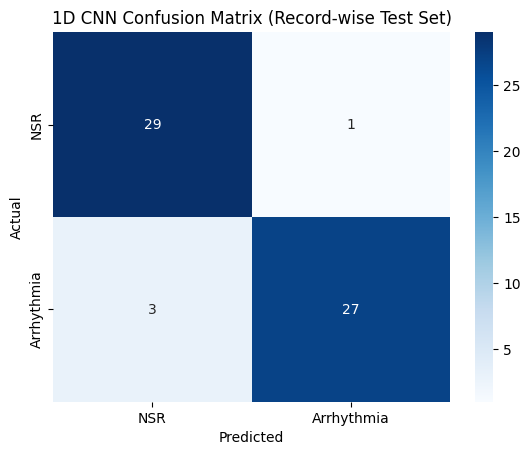

              precision    recall  f1-score   support

         NSR       0.91      0.97      0.94        30
  Arrhythmia       0.96      0.90      0.93        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_loss, test_acc = model_1d.evaluate(X1d_test, y_test_oh, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

y_pred = model_1d.predict(X1d_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = y_test  # already 0/1

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["NSR", "Arrhythmia"],
    yticklabels=["NSR", "Arrhythmia"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("1D CNN Confusion Matrix (Record-wise Test Set)")
plt.show()

print(classification_report(y_true_labels, y_pred_labels,
                            target_names=["NSR", "Arrhythmia"]))


Save the trained 1D model

In [ ]:
import os

save_dir = "/content/drive/MyDrive/ECG_Models"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "arrhythmia_1d_cnn_recordwise.h5")
model_1d.save(model_path)

print("Model saved to:", model_path)


Model saved to: /content/drive/MyDrive/ECG_Models/arrhythmia_1d_cnn_recordwise.h5
